# Coolab Settings

In [ ]:
# # code to change tf 2.x to 1.x
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# [Note Important] we have to uset tensorflow.keras...... 
# for imprting layers without that we are going to have really poor results.
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
import keras.backend as K
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.keras.backend.set_session(sess)
tf.random.set_random_seed(123)

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive/My Projects/Biometric Systems"
root_path = '/content/gdrive/My Drive/My Projects/Biometric Systems'

Biometric_Systems_Final.ipynb  forgeries_3_2.png  pickle_files
datasets		       models
FingerPrint.ipynb	       original_5_1.png


# Imports

In [ ]:
""" import the necessary packages """
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from sklearn.svm import SVC
import cv2
import glob
import pickle
import math
import time


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score, classification_report

""" tensorflow.keras imports """
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, save_model

%matplotlib inline


""" Code is from Scikit-learn website """
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Preprocessing

In [ ]:
class PreProcess:
    def __init__(self, dataset_name, datasetfile_pkl, IMAGE_WIDTH, IMAGE_HEIGHT):
        self.dataset_name = dataset_name
        self.datasetfile_pkl = datasetfile_pkl
        self.IMAGE_WIDTH, self.IMAGE_HEIGHT = IMAGE_WIDTH, IMAGE_HEIGHT

    # utils
    """ function to save data as pkl format to speed up the process of loading data as image every time."""
    def save_pkl_imgs(self, file_pkl, X_All, c_usr_All, Res_All):
        DATA_IMG = {}   
        DATA_IMG["X_All"] = X_All
        DATA_IMG["c_usr_All"] = c_usr_All
        DATA_IMG["Res_All"] = Res_All

        with open(file_pkl, "wb") as outfile: 
            pickle.dump(DATA_IMG, outfile)

    """ load pkl file of data """
    def load_pkl_imgs(self, file_pkl):
        DATA_IMG = pickle.load(open(file_pkl, "rb"))
        X_All = DATA_IMG["X_All"]
        c_usr_All = DATA_IMG["c_usr_All"]
        Res_All = DATA_IMG["Res_All"] 
        
        return X_All, c_usr_All, Res_All

    def get_UserName_Res(self, filenames):
        """ usr_all contains all users name based on the folder addresses, we name folders like user1 ... user55 for 55
        user and we read our categories in format of original_user1 for user1's original signature """
        print("[INFO] Getting username and Results ... from {}".format(self.dataset_name))
        usr_all = []
        Res_all = []
        for file in filenames:
            _,_,_,_,_,_,_,possibleForg, imgY, imgRes = file.split("/")
            x = imgRes.split("-")
            usr_all.append(imgY)
            if possibleForg == "forgeries":
                Res = 1
            if possibleForg == "original":
                Res = 0
            Res_all.append(Res)            
        
        return np.asarray(usr_all), np.asarray(Res_all)
        
    def get_Images(self, filenames):    
        print("[INFO] Getting Images ... from {}".format(self.dataset_name))
        """ reading all images as a grayscale images in 2D array format """
        X_all = []
        for filename in filenames:  
            img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
            img = 255 - img # invert the pixels signature pixels are around 200 in pixels
            img = cv2.resize(img,(IMAGE_WIDTH, IMAGE_HEIGHT))
            """ The function used is cv.threshold. First argument is the source image, which should be a grayscale image.
            Second argument is the threshold value which is used to classify the pixel values.
            Third argument is the maxVal which represents the value to be given if pixel value is
            more than (sometimes less than) the threshold value. """
            _, thresh1 = cv2.threshold(img, 10, 1, cv2.THRESH_BINARY) # return mask in binary format
            img = img * thresh1
            img = cv2.fastNlMeansDenoising(img, None, 10, 7, 21) 

            """ add channel to img and makes it in 3D format to feed as tensor to convolution layers -> (width,height,1) """
            img = np.expand_dims(img, axis=2)

            X_all.append(img) # (number of image, IMAGE_WIDTH, IMAGE_HEIGHT,3)
        
        return np.asarray(X_all)

    def PrepareDataForTrain(self, path):
        filenames = glob.glob(path)
        print("[INFO] Getting Data ... from {}".format(self.dataset_name))
        c_usr_All, Res_All = self.get_UserName_Res(filenames)
        X_All = self.get_Images(filenames)            
        print("X_All shape ", X_All.shape)
        print("c_usr_All shape ", c_usr_All.shape)
        print("Res_All shape ", Res_All.shape)
                
        print("[INFO] Saving Data in PKL Format ... to {}".format(self.dataset_name))
        self.save_pkl_imgs(self.datasetfile_pkl, X_All, c_usr_All, Res_All)
        print("[INFO] Data Saved in PKL Format ... to {}".format(self.datasetfile_pkl))

        return X_All, c_usr_All, Res_All

    def split_data(self, X_All, c_usr_All, Res_All, user_classes, numUsrForFL):
        """ this is function to split our data into 2 parts, we are going to use all signatures of some users 
        for part 1 and some users for part 2. we are creating two separate user sets to have WD form of learning
        part 1 is going to be used for train our CNN model for extracting features.
        part 2 will be used to test those features in WD form. """
        
        user_classes_WD = user_classes[numUsrForFL:]
        user_classes_FL = user_classes[0: numUsrForFL]

        X_FL, c_usr_FL, Res_FL = [], [], []
        X_WD, c_usr_WD, Res_WD = [], [], []

        for i, c_usr in enumerate(c_usr_All):
            if c_usr in user_classes_FL:
                X_FL.append(X_All[i])
                c_usr_FL.append(c_usr_All[i])
                Res_FL.append(Res_All[i])
            if c_usr in user_classes_WD:
                X_WD.append(X_All[i])
                c_usr_WD.append(c_usr_All[i])
                Res_WD.append(Res_All[i])

        X_FL = np.asarray(X_FL)
        c_usr_FL = np.asarray(c_usr_FL)
        Res_FL = np.asarray(Res_FL)
        X_WD = np.asarray(X_WD)
        c_usr_WD = np.asarray(c_usr_WD)
        Res_WD = np.asarray(Res_WD)

        return X_FL, c_usr_FL, Res_FL, X_WD, c_usr_WD, Res_WD, user_classes_WD, user_classes_FL

    def plot_9_images(self, images, cls_usr, cls_Res):
        # assert len(images) == len(cls_usr) == 9
        img_shape = (self.IMAGE_HEIGHT, self.IMAGE_WIDTH)
        # Create figure with 3x3 sub-plots.
        fig, axes = plt.subplots(3, 3, figsize=(10,10))    
        fig.subplots_adjust(hspace=0.1, wspace=0.1)
        for i, ax in enumerate(axes.flat):
            if i == len(images):
                break
            # Plot image.
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            xlabel = "User: {0}, Res: {1}".format(cls_usr[i], cls_Res[i])

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
        # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
        plt.show()


# Run Main()

In [ ]:
""" parameters """
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 220
read_data_again = False

dataset_name = "CEDAR" # CEDAR

# ========================================= CEDAR Preprocess ============================================
if dataset_name == "CEDAR":
    numUsrForFL = 40
    datasetfile_pkl = root_path + "/datasets/DATA_IMG_{}.pkl".format(dataset_name)
    datasetPath = root_path + "/datasets/{}/*/*/*.png".format(dataset_name) 
    print("[INFO] .... train on {}".format(datasetPath))

    preprocess = PreProcess(dataset_name, datasetfile_pkl, IMAGE_WIDTH, IMAGE_HEIGHT)    
    if read_data_again:
        X_All, c_usr_All, Res_All = preprocess.PrepareDataForTrain(datasetPath)         
    else:
        print("[INFO] Load Data from PKL Format ... {}".format(datasetfile_pkl))
        X_All, c_usr_All, Res_All = preprocess.load_pkl_imgs(datasetfile_pkl)

print("X_All shape: ", X_All.shape)
print("c_usr_All shape: ", c_usr_All.shape)
print("Res_All shape: ", Res_All.shape)


[INFO] .... train on /content/gdrive/My Drive/My Projects/Biometric Systems/datasets/CEDAR/*/*/*.png
[INFO] Load Data from PKL Format ... /content/gdrive/My Drive/My Projects/Biometric Systems/datasets/DATA_IMG_CEDAR.pkl
X_All shape:  (2640, 150, 220, 1)
c_usr_All shape:  (2640,)
Res_All shape:  (2640,)


In [ ]:
# ================= Split Data for Feature Learning and WD signature detection phases ===============
usrAllLabelBinarizer = LabelBinarizer()
usrAllLabelBinarizer.fit(c_usr_All)
user_classes = usrAllLabelBinarizer.classes_
print("all user_classes \n", user_classes)

X_FL, c_usr_FL, Res_FL, X_WD, c_usr_WD, Res_WD, user_classes_WD, user_classes_FL = preprocess.split_data(X_All, c_usr_All, Res_All, user_classes, numUsrForFL = numUsrForFL)

print("[INFO] c_usr_FL.shape", c_usr_FL.shape)
print("[INFO] c_usr_WD.shape", c_usr_WD.shape)
print("\n")
print("[INFO] user_classes_FL\n", user_classes_FL)
print("[INFO] user_classes_WD\n", user_classes_WD)
print("[INFO] X_FL shape: ", X_FL.shape)
print("[INFO] X_WD shape: ", X_WD.shape)

usrFL_LabelBinarizer = LabelBinarizer()
usrFL_LabelBinarizer.fit(c_usr_FL)
usr_FL_LB = usrFL_LabelBinarizer.transform(c_usr_FL)
print("[INFO] usr_FL_LB shape: ", usr_FL_LB.shape)



all user_classes 
 ['user_01' 'user_02' 'user_03' 'user_04' 'user_05' 'user_06' 'user_07'
 'user_08' 'user_09' 'user_10' 'user_11' 'user_12' 'user_13' 'user_14'
 'user_15' 'user_16' 'user_17' 'user_18' 'user_19' 'user_20' 'user_21'
 'user_22' 'user_23' 'user_24' 'user_25' 'user_26' 'user_27' 'user_28'
 'user_29' 'user_30' 'user_31' 'user_32' 'user_33' 'user_34' 'user_35'
 'user_36' 'user_37' 'user_38' 'user_39' 'user_40' 'user_41' 'user_42'
 'user_43' 'user_44' 'user_45' 'user_46' 'user_47' 'user_48' 'user_49'
 'user_50' 'user_51' 'user_52' 'user_53' 'user_54' 'user_55']
[INFO] c_usr_FL.shape (1920,)
[INFO] c_usr_WD.shape (720,)


[INFO] user_classes_FL
 ['user_01' 'user_02' 'user_03' 'user_04' 'user_05' 'user_06' 'user_07'
 'user_08' 'user_09' 'user_10' 'user_11' 'user_12' 'user_13' 'user_14'
 'user_15' 'user_16' 'user_17' 'user_18' 'user_19' 'user_20' 'user_21'
 'user_22' 'user_23' 'user_24' 'user_25' 'user_26' 'user_27' 'user_28'
 'user_29' 'user_30' 'user_31' 'user_32' 'user_33' 'u

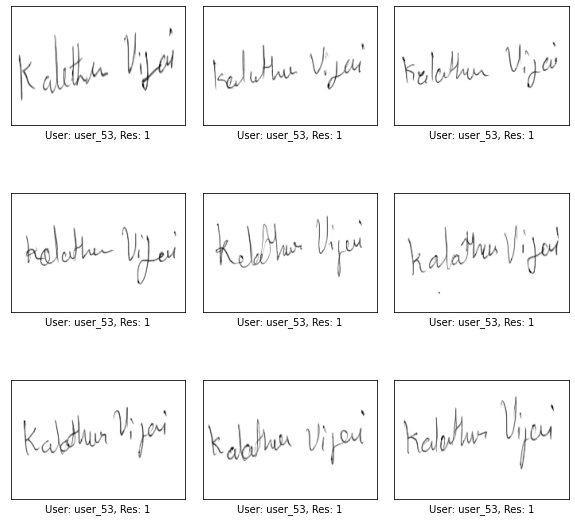

In [ ]:
images = X_All[25:34]
cls_usr = c_usr_All [25:34]
cls_Res = Res_All[25:34]
preprocess.plot_9_images(images, cls_usr, cls_Res)


In [ ]:
def getTrainWD_PerUser(X_WD, Res_WD, c_usr_WD, c_usr):
    X_perUsr_WD_Train, Res_perUsr_WD_Train, X_perUsr_WD_Test, Res_perUsr_WD_Test = [], [], [], []
    GenNumber, usrForgNumber, ForgNumber = 0, 0, 0
    for i, X in enumerate(X_WD):
        if c_usr_WD[i] == c_usr:
            if Res_WD[i] == 0:
                if GenNumber % 2 == 1: #half genuine to tain half to test 
                    X_perUsr_WD_Train.append(X_WD[i])
                    Res_perUsr_WD_Train.append(Res_WD[i])
                    X_perUsr_WD_Train.append(X_WD[i])
                    Res_perUsr_WD_Train.append(Res_WD[i])
                    X_perUsr_WD_Train.append(X_WD[i])
                    Res_perUsr_WD_Train.append(Res_WD[i])
                    GenNumber = GenNumber + 1
                else:
                    X_perUsr_WD_Test.append(X_WD[i])
                    Res_perUsr_WD_Test.append(Res_WD[i])
                    GenNumber = GenNumber + 1
            else: # all forgeries in test
                if usrForgNumber % 2 == 1:
                    X_perUsr_WD_Train.append(X_WD[i])
                    Res_perUsr_WD_Train.append(Res_WD[i])
                    X_perUsr_WD_Train.append(X_WD[i])
                    Res_perUsr_WD_Train.append(Res_WD[i])
                    X_perUsr_WD_Train.append(X_WD[i])
                    Res_perUsr_WD_Train.append(Res_WD[i])
                    usrForgNumber = usrForgNumber + 1
                else:
                    X_perUsr_WD_Test.append(X_WD[i])
                    Res_perUsr_WD_Test.append(Res_WD[i])
                    usrForgNumber = usrForgNumber + 1

    X_perUsr_WD_Train = np.asarray(X_perUsr_WD_Train)
    Res_perUsr_WD_Train = np.asarray(Res_perUsr_WD_Train)
    X_perUsr_WD_Test = np.asarray(X_perUsr_WD_Test)
    Res_perUsr_WD_Test = np.asarray(Res_perUsr_WD_Test)

    return X_perUsr_WD_Train, Res_perUsr_WD_Train, X_perUsr_WD_Test, Res_perUsr_WD_Test


def train_ReportResults(TrainFeature, Res_perUsr_WD_Train, TestFeature, Res_perUsr_WD_Test):
    clf =  SVC(kernel="rbf", C=1000, gamma='scale', probability=False)
    clf.fit(TrainFeature, Res_perUsr_WD_Train)
    ensemble_pred = clf.predict(TestFeature)
    classesRes = [0,1]
    from sklearn import metrics

    cnf_matrix_Res = confusion_matrix(Res_perUsr_WD_Test, ensemble_pred, labels=classesRes)

    TP_Res = cnf_matrix_Res[0][0]
    TN_Res = cnf_matrix_Res[1][1]
    FN_Res = cnf_matrix_Res[0][1]
    FP_Res = cnf_matrix_Res[1][0]

    FAR = FP_Res / (FP_Res + TN_Res) 
    FRR = FN_Res / (TP_Res + FN_Res)
    EER = (FRR + FAR)/2
    
    return FAR, FRR, EER

# CNN Model Train

In [ ]:
class TrainCNN:
    def __init__(self, model, NumOfUser, originalPaper, origEpochs, ourEpoch, batch_size, IMAGE_WIDTH, IMAGE_HEIGHT, dataset_name, fc1_Size, fc2_Size):
        self.NumOfUser = NumOfUser
        self.originalPaper = originalPaper
        self.batch_size = batch_size
        self.IMAGE_WIDTH, self.IMAGE_HEIGHT = IMAGE_WIDTH, IMAGE_HEIGHT
        self.dataset_name = dataset_name
        self.fc1_Size, self.fc2_Size = fc1_Size, fc2_Size

        """ we are going to use this H list for storing history returned by our model for plot porpuses. """  
        self.history = []
        self.model = model

        """ formatting Model file addrresses """
        if originalPaper:
            print("INFO .... Original Paper Model")
            self.model_file = root_path + "/models/BioSys_OriginalPaper_CNN_Model_{}".format(self.dataset_name)
            self.EPOCHS = origEpochs # epochs for train with each learning rate
        else:
            print("INFO .... Our Model")
            self.model_file = root_path + "/models/BioSys_My_CNN_Model_{}".format(self.dataset_name)
            self.EPOCHS = ourEpoch # epochs for train with each learning rate  

    """ Save model """
    def save_CNN_model(self, skf_number):        
        save_model(self.model, self.model_file + "_skf_num_{}.h5".format(skf_number))
        print("INFO .... Model Saved ..... ")

    """ load model """
    def load_CNN_model(self, skf_number):        
        self.model = load_model(self.model_file + "_skf_num_{}.h5".format(skf_number))
        print("INFO .... Model Loaded .... ")
        

    def pltHistoryCallBack(self):
        # function to plot the loss for both the training and validation data
        def plotLoss(lossName, lossTrain, lossVal):            
            title = "Loss for {}".format(lossName) if lossName != "loss" else "Total loss"
            plt.figure(figsize=(10, 5))
            plt.title(title)
            plt.xlabel("Epoch #")
            plt.ylabel("Loss")
            plt.plot(lossTrain, label=lossName)
            plt.plot(lossVal, label="val_" + lossName)
            plt.legend()
            plt.tight_layout()
            plt.show()
            plt.close()

        # function to plot the accuracy for both the training and validation data
        def plotAcc(AccName, AccTrain, AccVal):            
            title = "Accuracy for {}".format(AccName)
            plt.figure(figsize=(10, 5))
            plt.title(title)
            plt.xlabel("Epoch #")
            plt.ylabel("Accuracy")
            plt.plot(AccTrain, label=AccName)
            plt.plot(AccVal, label="val_" + AccName)
            plt.legend()
            plt.tight_layout()
            plt.show()
            plt.close()

        # getting train losses and acc from callBack history
        train_loss = np.mean(self.history.history["loss"], axis=1)
        train_User_loss = self.history.history["User_loss"]
        train_Res_loss = self.history.history["Res_loss"]
        train_User_acc = self.history.history["User_acc"]
        train_Res_acc = self.history.history["Res_acc"]

        # getting validation losses and acc from callBack history
        val_loss = np.mean(self.history.history["val_loss"], axis=1)
        val_User_loss = self.history.history["val_User_loss"]
        val_Res_loss = self.history.history["val_Res_loss"]
        val_User_acc = self.history.history["val_User_acc"]
        val_Res_acc = self.history.history["val_Res_acc"]

        # plotting losses
        lossName, lossTrain, lossVal = "loss", train_loss, val_loss
        plotLoss(lossName, lossTrain, lossVal)

        lossName, lossTrain, lossVal = "User_loss", train_User_loss, val_User_loss
        plotLoss(lossName, lossTrain, lossVal)

        lossName, lossTrain, lossVal = "Res_loss", train_Res_loss, val_Res_loss
        plotLoss(lossName, lossTrain, lossVal)

        print("\n")

        # plotting accuracies
        AccName, AccTrain, AccVal = "User_acc", train_User_acc, val_User_acc
        plotAcc(AccName, AccTrain, AccVal)

        AccName, AccTrain, AccVal = "Res_acc", train_Res_acc, val_Res_acc
        plotAcc(AccName, AccTrain, AccVal) 

    """ ///////////////////////////// Build CNN ///////////////////////////////////////////////// """
    def build_OurCNN_model(self, inputs):
        # val_User_acc: 1.0000 - val_Res_acc: 0.9874
        x = Conv2D(96, (11,11), strides=3, padding= 'valid', activation='relu', kernel_regularizer = regularizers.l2(0.01))(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D((3,3), strides=2, padding='same')(x)
        x = Conv2D(256, (5,5), strides=1, padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((3,3), strides=2, padding='same')(x)
        x = Conv2D(384, (3,3), strides=1, padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Conv2D(384, (3,3), strides=1, padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((3,3), strides=2, padding='same')(x)
        x = Dropout(0.5)(x)
        x = Conv2D(256, (3,3), strides=1, padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((3,3), strides=2, padding='same')(x)
        x = Flatten()(x)

        x = Dense(units = self.fc1_Size , activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dense(units = self.fc2_Size, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)

        user_Model = Dense(units = self.NumOfUser,  kernel_regularizer=regularizers.l2(0.01))(x)
        Res_Model = Dense(units = 1,  kernel_regularizer=regularizers.l2(0.01))(x)
        user_Model = Activation("softmax", name = "User")(user_Model)
        Res_Model = Activation("sigmoid", name = "Res")(Res_Model)
        return user_Model, Res_Model

    """ ///////////////////////////// Build CNN ///////////////////////////////////////////////// """
    def build_Paper_model(self, inputs):
        x = Conv2D(96, (11,11), strides=3, padding= 'valid', activation='relu', kernel_regularizer = regularizers.l2(0.01))(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D((3,3), strides=2, padding='same')(x)
        x = Conv2D(256, (5,5), strides=1, padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((3,3), strides=2, padding='same')(x)
        x = Conv2D(384, (3,3), strides=1, padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Conv2D(384, (3,3), strides=1, padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Conv2D(256, (3,3), strides=1, padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((3,3), strides=2, padding='same')(x)
        x = Dropout(0.5)(x)
        x = Flatten()(x)

        x = Dense(units = 2048 , activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = Dense(units = 2048, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)

        user_Model = Dense(units = self.NumOfUser,  kernel_regularizer=regularizers.l2(0.01))(x)
        Res_Model = Dense(units = 1,  kernel_regularizer=regularizers.l2(0.01))(x)
        user_Model = Activation("softmax", name = "User")(user_Model)
        Res_Model = Activation("sigmoid", name = "Res")(Res_Model)
        
        return user_Model, Res_Model

    def train(self, X_Train, usr_Train_LB, Res_Train, X_Test, usr_Test_LB, Res_Test):
        LamdaWeight = 0.7
        lr = 1e-4
        """ we defined two dictionaries: one that specifies the loss method for each output of the network
        along with a second dictionary that specifies the weight per loss """
        losses = { "User": "categorical_crossentropy", "Res": "binary_crossentropy"}

        """ initialize our multi-output network, softmax for users because they are many and sigmoid
        for genuine(0) or forgery(1) becuase its binary """
        inputShape = (self.IMAGE_HEIGHT, self.IMAGE_WIDTH, 1)
        inputs = Input(shape = inputShape)
        """ it's Hyperparameter Lambda that we use for trade-off between 2 loss function as used in paper """          
        lossWeights = {"User": (1-LamdaWeight) * (1-Res_Train), "Res": LamdaWeight}
        
        if self.originalPaper:
            print("[INFO] .... original paper model training .... ")
            User, Res = self.build_Paper_model(inputs)
        else:
            print("[INFO] .... our CNN model training .... ")
            User, Res = self.build_OurCNN_model(inputs)

        self.model = Model(inputs = inputs, outputs = [User, Res], name = "SigNet")  

        # This function keeps the learning rate at 0.001 for the first ten epochs and decreases it exponentially after that.
        def scheduler(epoch, lr):
            if epoch % self.EPOCHS == 0:
                print("[INFO] lr is  ... ", lr*1e-1)
                return lr*1e-1
            else:
                return lr

        callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

        """ initialize the optimizer and compile the model """
        opt = SGD(lr=lr, momentum=0.9, decay=1e-4, nesterov=True)

        """ train the network to perform multi-class classification """
        self.model.compile(optimizer = opt, loss = losses, loss_weights = lossWeights, metrics=["accuracy"])     

        """ model training """
        self.history = self.model.fit(X_Train, {"User": usr_Train_LB, "Res": Res_Train}, validation_data = (X_Test, {"User": usr_Test_LB, "Res": Res_Test}), 
                    epochs = 120, callbacks=[callback], batch_size = self.batch_size, verbose = 2)          # verbose=0 will show you nothing (silent), verbose=1 will show you an animated progress bar. verbose=2 will just mention the number of epochs
        
    
    # function to predict both output values
    def predict(self, usr_pred_proba, Res_pred_proba, usrclasses_, threshold):
        """ User prediction section based on argmax """
        usrClasses = usrclasses_
        usr_pred = []
        for i in range(len(usr_pred_proba)):
            usr_pred.append(usrClasses[np.argmax(usr_pred_proba[i], axis = 0)])

        """ Genuine or Forgery Prediction as Result """
        Res_pred = []
        for i in range(len(Res_pred_proba)):
            Res_pred.append(1 if Res_pred_proba[i] >= threshold else 0)

        return usr_pred, Res_pred

    # function to return probability of predictions for users as vector of size number of users.    
    def predict_usr_proba(self, x_data):
        pred = self.model.predict(x_data)
        return pred[0][:]

    # function to return probability of predictions for res as one float number between [0,1]
    def predict_Res_proba(self, x_data):
        pred = self.model.predict(x_data)
        return pred[1][:]


# Run TrainCNN

In [ ]:
# =========================== Run Train CNN Code with KFOLD and  fc1_Size, fc2_Size = 1024, 512 ============================================
TRAIN = True
originalPaper = False
origEpochs = 20
ourEpoch = 30
batch_size = 64

num_usr_FL = len(usr_FL_LB[1])
dataset_name1 = dataset_name
fc1_Size, fc2_Size = 1024, 1024

print("------------------------------------- FC sizes = ", fc1_Size, fc2_Size, "-------------------------------------------")
start_time = time.clock()
skf_number = 0

skf = StratifiedKFold(n_splits= 5)
skf_FAR_All, skf_FRR_All, skf_EER_All, skf_scoreUsr, skf_scoreRes = [],[],[],[],[]
for train, test in skf.split(X_FL, c_usr_FL):   
    start_time_Fold = time.clock()
    X_Train_FL, X_Test_FL = X_FL[train] , X_FL[test]
    usr_Train_FL, usr_Test_FL = usr_FL_LB[train], usr_FL_LB[test]
    Res_Train_FL, Res_Test_FL = Res_FL[train], Res_FL[test]
    c_usr_Train_FL, c_usr_Test_FL = c_usr_FL[train], c_usr_FL[test]

    skf_number+=1 
    model = None
    trainCNN = TrainCNN(model, num_usr_FL, originalPaper, origEpochs, ourEpoch, batch_size,\
                        IMAGE_WIDTH, IMAGE_HEIGHT, dataset_name1, fc1_Size, fc2_Size)
    
    trainCNN.train(X_Train_FL, usr_Train_FL, Res_Train_FL, X_Test_FL, usr_Test_FL, Res_Test_FL)
    trainCNN.save_CNN_model(skf_number)
    """ accuracy of model """
    score = trainCNN.model.evaluate(X_Test_FL, {"User": usr_Test_FL, "Res": Res_Test_FL})
    print("[INFO] skf_number: ", skf_number ," accuaracy of User: ", score[-2], "accuaracy of Res: ", score[-1])
    skf_scoreUsr.append(score[-2])
    skf_scoreRes.append(score[-1])

    # getting the last FC layer
    model1 = Model(inputs= trainCNN.model.inputs, outputs= trainCNN.model.layers[-5].output)
    FAR_All, FRR_All, EER_All = [],[],[]

    for c_usr in user_classes_WD:    
        X_perUsr_WD_Train, Res_perUsr_WD_Train, X_perUsr_WD_Test, Res_perUsr_WD_Test = getTrainWD_PerUser(X_WD, Res_WD, c_usr_WD, c_usr)
        
        # get extracted features
        TrainFeature = model1.predict(X_perUsr_WD_Train)
        TestFeature = model1.predict(X_perUsr_WD_Test)

        FAR, FRR, EER = train_ReportResults(TrainFeature, Res_perUsr_WD_Train, TestFeature, Res_perUsr_WD_Test)
        
        FAR_All.append(FAR)
        FRR_All.append(FRR)
        EER_All.append(EER)

    print("FAR_All mean = ", np.mean(FAR_All))
    print("FRR_All mean = ", np.mean(FRR_All))
    print("EER_All mean = ", np.mean(EER_All))

    skf_FAR_All.append(np.mean(FAR_All))
    skf_FRR_All.append(np.mean(FRR_All))
    skf_EER_All.append(np.mean(EER_All))
    running_time_Fold = (time.clock() - start_time_Fold)/60 # in minutes
    print(running_time_Fold, "minutes")
    
print("skf_FAR_All mean = ", np.mean(skf_FAR_All))
print("skf_FRR_All mean = ", np.mean(skf_FRR_All))
print("skf_EER_All mean = ", np.mean(skf_EER_All))
print("skf_scoreUsr mean = ", np.mean(skf_scoreUsr))
print("skf_scoreRes mean = ", np.mean(skf_scoreRes))
print("======================================================================")

running_time = (time.clock() - start_time)/60 # in minutes
print(running_time, "minutes")



------------------------------------- FC sizes =  1024 1024 -------------------------------------------
INFO .... Our Model
[INFO] .... our CNN model training .... 
Train on 1536 samples, validate on 384 samples
[INFO] lr is  ...  9.999999747378752e-06
Epoch 1/120
1536/1536 - 4s - loss: 38.3109 - User_loss: 3.2794 - Res_loss: 0.0704 - User_acc: 0.1921 - Res_acc: 0.9674 - val_loss: 52.5763 - val_User_loss: 89.4116 - val_Res_loss: 0.0000e+00 - val_User_acc: 0.0286 - val_Res_acc: 1.0000
Epoch 2/120
1536/1536 - 1s - loss: 33.8273 - User_loss: 1.3578 - Res_loss: 0.0033 - User_acc: 0.6133 - Res_acc: 0.9993 - val_loss: 35.2551 - val_User_loss: 21.9980 - val_Res_loss: 8.0883e-26 - val_User_acc: 0.0521 - val_Res_acc: 1.0000
Epoch 3/120
1536/1536 - 1s - loss: 29.1500 - User_loss: 0.6508 - Res_loss: 0.0102 - User_acc: 0.8346 - Res_acc: 0.9980 - val_loss: 27.6829 - val_User_loss: 4.5576 - val_Res_loss: 5.3790e-08 - val_User_acc: 0.1797 - val_Res_acc: 1.0000
Epoch 4/120
1536/1536 - 1s - loss: 25.06

# Evaluation Section

In [ ]:
# =========================== Run Train CNN Code with KFOLD and  fc1_Size, fc2_Size = 1024, 512 ============================================
TRAIN = True
originalPaper = False
origEpochs = 20
ourEpoch = 30
batch_size = 64

num_usr_FL = len(usr_FL_LB[1])
dataset_name1 = dataset_name
fc1_Size, fc2_Size = 1024, 1024

print("------------------------------------- FC sizes = ", fc1_Size, fc2_Size, "-------------------------------------------")
start_time = time.clock()
X_Train_FL, X_Test_FL, usr_Train_FL, usr_Test_FL, Res_Train_FL, Res_Test_FL, c_usr_Train_FL, c_usr_Test_FL = train_test_split(X_FL, usr_FL_LB, Res_FL, c_usr_FL, test_size= 0.2, stratify = c_usr_FL)
model = None
trainCNN = TrainCNN(model, num_usr_FL, originalPaper, origEpochs, ourEpoch, batch_size, IMAGE_WIDTH, IMAGE_HEIGHT, dataset_name1, fc1_Size, fc2_Size)

if TRAIN:
    trainCNN.train(X_Train_FL, usr_Train_FL, Res_Train_FL, X_Test_FL, usr_Test_FL, Res_Test_FL)
    trainCNN.save_CNN_model(20) # to save it different from other models in KFOLD
else:
    trainCNN.load_CNN_model(20)

""" accuracy of model """
score = trainCNN.model.evaluate(X_Test_FL, {"User": usr_Test_FL, "Res": Res_Test_FL})
print("accuaracy of User: ", score[-2], "accuaracy of Res: ", score[-1]) # just to get accuracy of User and Res

# getting the last FC layer
model1 = Model(inputs= trainCNN.model.inputs, outputs= trainCNN.model.layers[-5].output)

FAR_All, FRR_All, EER_All = [],[],[]

for c_usr in user_classes_WD:    
    X_perUsr_WD_Train, Res_perUsr_WD_Train, X_perUsr_WD_Test, Res_perUsr_WD_Test = getTrainWD_PerUser(X_WD, Res_WD, c_usr_WD, c_usr)
    
    # get extracted features
    TrainFeature = model1.predict(X_perUsr_WD_Train)
    TestFeature = model1.predict(X_perUsr_WD_Test)

    FAR, FRR, EER = train_ReportResults(TrainFeature, Res_perUsr_WD_Train, TestFeature, Res_perUsr_WD_Test)
    
    FAR_All.append(FAR)
    FRR_All.append(FRR)
    EER_All.append(EER)

print("FAR_All mean = ", np.mean(FAR_All))
print("FRR_All mean = ", np.mean(FRR_All))
print("EER_All mean = ", np.mean(EER_All))

running_time = (time.clock() - start_time)/60 # in minutes
print(running_time, "minutes")



------------------------------------- FC sizes =  1024 1024 -------------------------------------------
INFO .... Our Model
[INFO] .... our CNN model training .... 
Train on 1536 samples, validate on 384 samples
[INFO] lr is  ...  9.999999747378752e-06
Epoch 1/120
1536/1536 - 3s - loss: 39.6523 - User_loss: 2.6535 - Res_loss: 0.0759 - User_acc: 0.3236 - Res_acc: 0.9668 - val_loss: 451.9854 - val_User_loss: 448.1505 - val_Res_loss: 190.0836 - val_User_acc: 0.0260 - val_Res_acc: 0.5078
Epoch 2/120
1536/1536 - 1s - loss: 35.2038 - User_loss: 0.7793 - Res_loss: 0.0055 - User_acc: 0.7715 - Res_acc: 0.9987 - val_loss: 87.1187 - val_User_loss: 54.4569 - val_Res_loss: 27.4082 - val_User_acc: 0.0495 - val_Res_acc: 0.5078
Epoch 3/120
1536/1536 - 1s - loss: 30.3858 - User_loss: 0.3444 - Res_loss: 0.0050 - User_acc: 0.9108 - Res_acc: 0.9993 - val_loss: 35.8490 - val_User_loss: 10.2780 - val_Res_loss: 2.7462 - val_User_acc: 0.1094 - val_Res_acc: 0.5859
Epoch 4/120
1536/1536 - 1s - loss: 26.1339 - U

Model: "SigNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 220, 1) 0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 47, 70, 96)   11712       input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 47, 70, 96)   384         conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 24, 35, 96)   0           batch_normalization_35[0][0]     
_____________________________________________________________________________________________

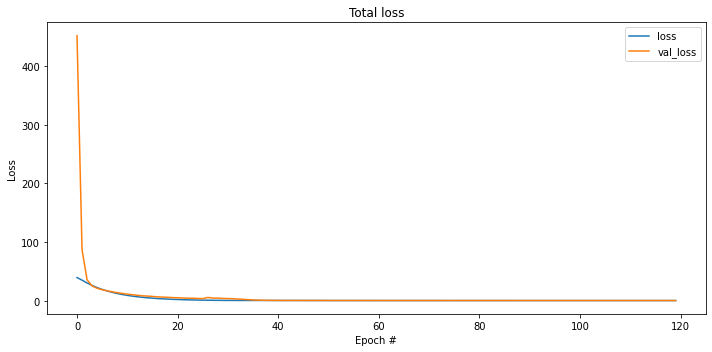

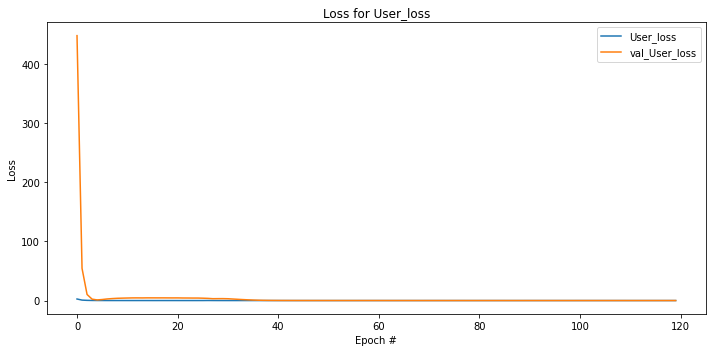

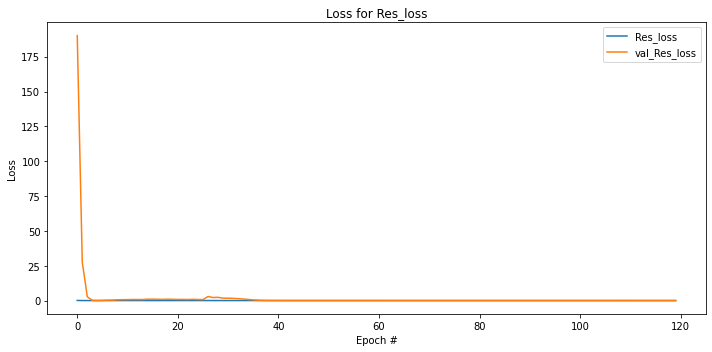

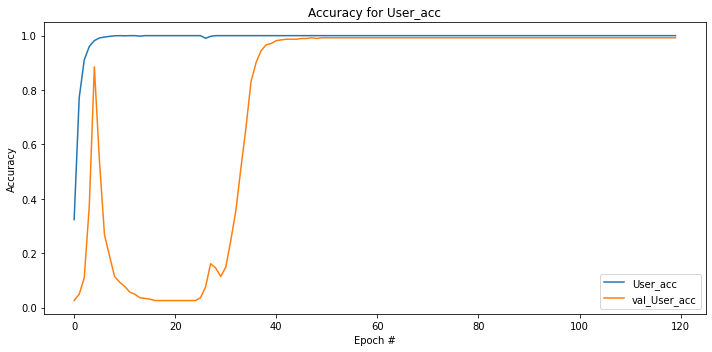

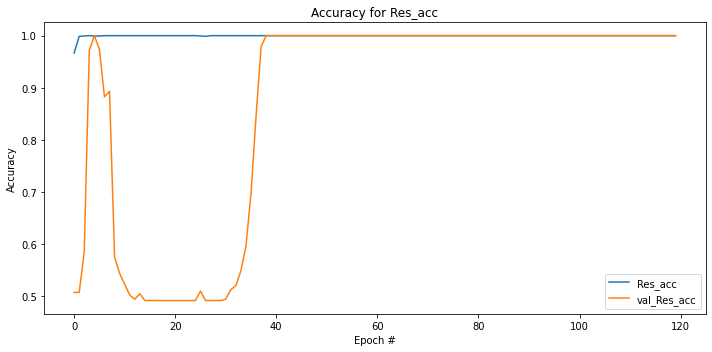

In [ ]:
""" summary model """
trainCNN.model.summary()

""" plot loss and accuracy plot for all epochs """
trainCNN.pltHistoryCallBack()

In [ ]:
def Res_Classification_Evaluation(trainCNN, X_Test, c_usr_Test, Res_Test, thresholds, usrclasses_):
    EER_Res, FAR_Res, FRR_Res = [],[],[]    
    Res_pred_proba = trainCNN.predict_Res_proba(X_Test)
    Roc_Auc_Score_Res = roc_auc_score(Res_Test, Res_pred_proba)
    print("Roc_Auc_Score_Res = ", Roc_Auc_Score_Res)

    usr_pred_proba = trainCNN.predict_usr_proba(X_Test)
    Roc_Auc_Score_usr = roc_auc_score(c_usr_Test, usr_pred_proba, multi_class = "ovo")
    print("Roc_Auc_Score_usr = ", Roc_Auc_Score_usr)

    print("\n =================================================\n")
    for threshold in thresholds:
        usr_pred, Res_pred = trainCNN.predict(usr_pred_proba, Res_pred_proba, usrclasses_, threshold)
        print("accuracy of Res : ", accuracy_score(Res_Test, Res_pred, normalize=True) )
        print("accuracy of User : ", accuracy_score(c_usr_Test, usr_pred, normalize=True) )

        print(metrics.classification_report(Res_Test, Res_pred, digits=3))
        classesRes = [0,1]
        cnf_matrix_Res = confusion_matrix(Res_Test, Res_pred, labels= classesRes)   

         # https://www.geeksforgeeks.org/confusion-matrix-machine-learning/ 
        
        TP_Res = cnf_matrix_Res[0][0]
        TN_Res = cnf_matrix_Res[1][1]
        FN_Res = cnf_matrix_Res[0][1]
        FP_Res = cnf_matrix_Res[1][0]

        FAR = FP_Res / (FP_Res + TN_Res) 
        FRR = FN_Res / (TP_Res + FN_Res)
        EER = (FRR + FAR)/2
        # EER or AER is AER = (FRR + FARrandom + FARsimple + FARskilled)/4. in our case just = (FRR + FARskilled)/2

        print("FAR = ", FAR, "With Threshold of: ", threshold)
        print("FRR = ", FRR, "With Threshold of: ", threshold)
        print("EER = ", EER, "With Threshold of: ", threshold)
        FAR_Res.append(FAR)
        FRR_Res.append(FRR)
        EER_Res.append(EER)
        plt.figure()
        plot_confusion_matrix(cnf_matrix_Res, classes=classesRes, normalize=False, title='confusion matrix')
        plt.show()
        plt.tight_layout()  
        plt.close()  
        print("============================================================ \n")
        
    return EER_Res, FAR_Res, FRR_Res

def ERR_FAR_vs_FRR_plot(FAR_Res, FRR_Res, thresholds):
    """ curve for best ERR """
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, FAR_Res, color='darkorange', lw=2, label='FAR')
    plt.plot(thresholds, FRR_Res, color='blue', lw=2, label='FRR')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Treshold')
    plt.ylabel('Error Rate')
    plt.title('ERR for Acceptance threshold ')
    plt.legend(loc="lower right")
    plt.show()


def ROC_Curve_plot(FAR_Res, FRR_Res):
    """ ROC (Receiver Operating Characteristic) """
    plt.figure(figsize=(10,5))
    plt.plot(FAR_Res, np.ones(shape= len(FRR_Res))-FRR_Res, color='darkorange', lw=2, label='FAR - (1-FRR)')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FAR')
    plt.ylabel('1-FRR')
    plt.title('ROC (Receiver Operating Characteristic) ')
    plt.legend(loc="lower right")
    plt.show()

def plot_9_pred_images(images, width, height, cls_true, cls_pred=None):
    # assert len(images) == len(cls_true) == 9
    img_shape = (height, width)
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(9,9))    
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i == len(images):
            break
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        # Show true and predicted classes. 
        if cls_pred is not None:
            xlabel = "Tr: {0}, Pr: {1}".format(cls_true[i], cls_pred[i])
        else:
            xlabel = "Tr: {0} ".format(cls_true[i])
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()    

def user_Identification_Evaluaion(trainCNN, X_Test, c_usr_Test, classesUser):
    """ Confusion matrix for Users """
    usr_pred_proba = trainCNN.predict_usr_proba(X_Test)
    Res_pred_proba = trainCNN.predict_Res_proba(X_Test)
    Roc_Auc_Score_usr = roc_auc_score(c_usr_Test, usr_pred_proba, multi_class = "ovo")
    print("Roc_Auc_Score_usr = ", Roc_Auc_Score_usr)

    usr_pred, Res_pred = trainCNN.predict(usr_pred_proba, Res_pred_proba, classesUser, threshold = 0.5)
    cnf_matrix_usr = confusion_matrix(c_usr_Test, usr_pred) 
    TN_usr, TP_usr, FP_usr, FN_usr = [],[],[],[]

    for i in range(len(classesUser)):
        TN_tmp, TP_tmp, FP_tmp, FN_tmp = 0,0,0,0
        for j in range(len(cnf_matrix_usr)):
            for k in range(len(cnf_matrix_usr)):                           
                if (k == j) and (k != i):
                    TN_tmp += cnf_matrix_usr[k][j]                
                if (k == j) and (k == i):    
                    TP_tmp += cnf_matrix_usr[k][j]                
                if (k != j) and (j != i) and (j == i):
                    FP_tmp += cnf_matrix_usr[k][j]
                if (k != j) and (k == i):                 
                    FN_tmp += cnf_matrix_usr[k][j]
        
        TN_usr.append(TN_tmp)
        TP_usr.append(TP_tmp)
        FP_usr.append(FP_tmp)
        FN_usr.append(FN_tmp)                

    TN_usr = np.asarray(TN_usr)
    TP_usr = np.asarray(TP_usr)
    FP_usr = np.asarray(FP_usr)
    FN_usr = np.asarray(FN_usr)
    print("\n")
    print("TN_usr = ", sum(TN_usr))
    print("TP_usr = ", sum(TP_usr))
    print("FP_usr = ", sum(FP_usr))
    print("FN_usr = ", sum(FN_usr))
    FAR_usr = FP_usr / (FP_usr + TN_usr)
    FRR_usr = FN_usr / (TP_usr + FN_usr)
    print("FAR_usr = ", FAR_usr)
    print("FRR_usr = ", FRR_usr)
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(cnf_matrix_usr, classes=classesUser, normalize=False, title='confusion matrix')
    plt.show()
    plt.close()

    return cnf_matrix_usr

Roc_Auc_Score_Res =  1.0
Roc_Auc_Score_usr =  0.9999857549857549


accuracy of Res :  0.5078125
accuracy of User :  0.9921875
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       189
           1      0.508     1.000     0.674       195

    accuracy                          0.508       384
   macro avg      0.254     0.500     0.337       384
weighted avg      0.258     0.508     0.342       384

FAR =  0.0 With Threshold of:  0.0
FRR =  1.0 With Threshold of:  0.0
EER =  0.5 With Threshold of:  0.0
Confusion matrix, without normalization


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


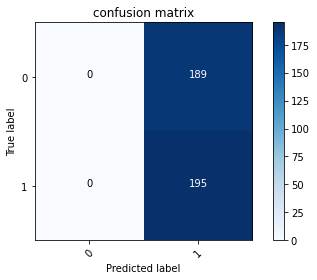


accuracy of Res :  1.0
accuracy of User :  0.9921875
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       189
           1      1.000     1.000     1.000       195

    accuracy                          1.000       384
   macro avg      1.000     1.000     1.000       384
weighted avg      1.000     1.000     1.000       384

FAR =  0.0 With Threshold of:  0.1
FRR =  0.0 With Threshold of:  0.1
EER =  0.0 With Threshold of:  0.1
Confusion matrix, without normalization


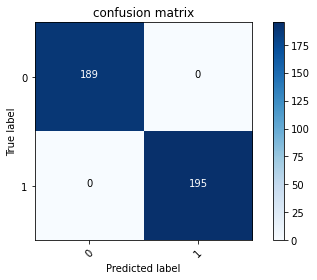


accuracy of Res :  1.0
accuracy of User :  0.9921875
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       189
           1      1.000     1.000     1.000       195

    accuracy                          1.000       384
   macro avg      1.000     1.000     1.000       384
weighted avg      1.000     1.000     1.000       384

FAR =  0.0 With Threshold of:  0.2
FRR =  0.0 With Threshold of:  0.2
EER =  0.0 With Threshold of:  0.2
Confusion matrix, without normalization


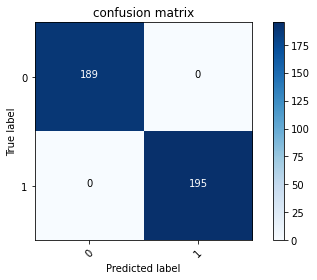


accuracy of Res :  1.0
accuracy of User :  0.9921875
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       189
           1      1.000     1.000     1.000       195

    accuracy                          1.000       384
   macro avg      1.000     1.000     1.000       384
weighted avg      1.000     1.000     1.000       384

FAR =  0.0 With Threshold of:  0.30000000000000004
FRR =  0.0 With Threshold of:  0.30000000000000004
EER =  0.0 With Threshold of:  0.30000000000000004
Confusion matrix, without normalization


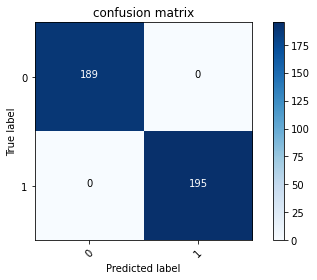


accuracy of Res :  1.0
accuracy of User :  0.9921875
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       189
           1      1.000     1.000     1.000       195

    accuracy                          1.000       384
   macro avg      1.000     1.000     1.000       384
weighted avg      1.000     1.000     1.000       384

FAR =  0.0 With Threshold of:  0.4
FRR =  0.0 With Threshold of:  0.4
EER =  0.0 With Threshold of:  0.4
Confusion matrix, without normalization


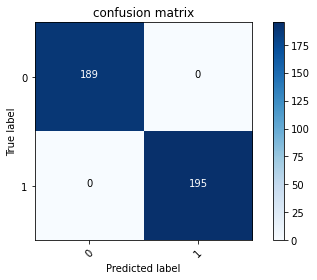


accuracy of Res :  1.0
accuracy of User :  0.9921875
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       189
           1      1.000     1.000     1.000       195

    accuracy                          1.000       384
   macro avg      1.000     1.000     1.000       384
weighted avg      1.000     1.000     1.000       384

FAR =  0.0 With Threshold of:  0.5
FRR =  0.0 With Threshold of:  0.5
EER =  0.0 With Threshold of:  0.5
Confusion matrix, without normalization


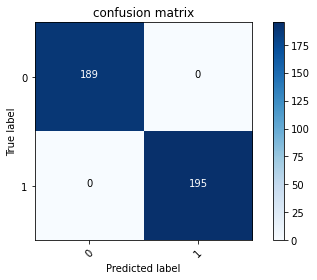


accuracy of Res :  1.0
accuracy of User :  0.9921875
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       189
           1      1.000     1.000     1.000       195

    accuracy                          1.000       384
   macro avg      1.000     1.000     1.000       384
weighted avg      1.000     1.000     1.000       384

FAR =  0.0 With Threshold of:  0.6000000000000001
FRR =  0.0 With Threshold of:  0.6000000000000001
EER =  0.0 With Threshold of:  0.6000000000000001
Confusion matrix, without normalization


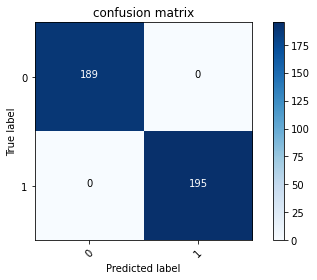


accuracy of Res :  1.0
accuracy of User :  0.9921875
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       189
           1      1.000     1.000     1.000       195

    accuracy                          1.000       384
   macro avg      1.000     1.000     1.000       384
weighted avg      1.000     1.000     1.000       384

FAR =  0.0 With Threshold of:  0.7000000000000001
FRR =  0.0 With Threshold of:  0.7000000000000001
EER =  0.0 With Threshold of:  0.7000000000000001
Confusion matrix, without normalization


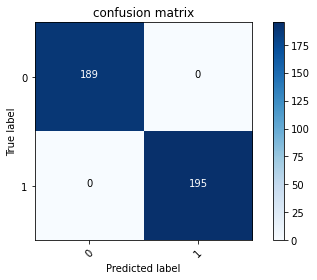


accuracy of Res :  1.0
accuracy of User :  0.9921875
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       189
           1      1.000     1.000     1.000       195

    accuracy                          1.000       384
   macro avg      1.000     1.000     1.000       384
weighted avg      1.000     1.000     1.000       384

FAR =  0.0 With Threshold of:  0.8
FRR =  0.0 With Threshold of:  0.8
EER =  0.0 With Threshold of:  0.8
Confusion matrix, without normalization


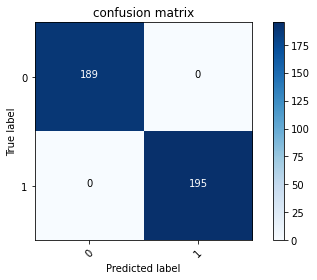


accuracy of Res :  1.0
accuracy of User :  0.9921875
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       189
           1      1.000     1.000     1.000       195

    accuracy                          1.000       384
   macro avg      1.000     1.000     1.000       384
weighted avg      1.000     1.000     1.000       384

FAR =  0.0 With Threshold of:  0.9
FRR =  0.0 With Threshold of:  0.9
EER =  0.0 With Threshold of:  0.9
Confusion matrix, without normalization


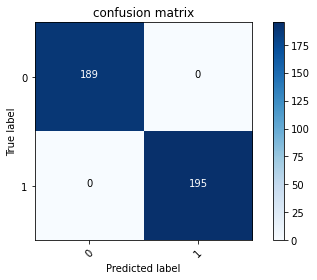


accuracy of Res :  0.4921875
accuracy of User :  0.9921875
              precision    recall  f1-score   support

           0      0.492     1.000     0.660       189
           1      0.000     0.000     0.000       195

    accuracy                          0.492       384
   macro avg      0.246     0.500     0.330       384
weighted avg      0.242     0.492     0.325       384

FAR =  1.0 With Threshold of:  1.0
FRR =  0.0 With Threshold of:  1.0
EER =  0.5 With Threshold of:  1.0
Confusion matrix, without normalization


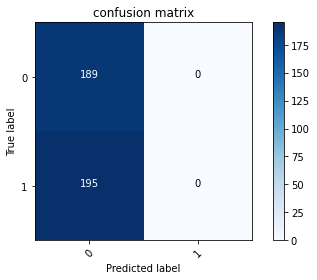

In [ ]:
thresholds = np.arange(start=0, stop=1.01, step=0.1)
EER_Res, FAR_Res, FRR_Res = Res_Classification_Evaluation(trainCNN, X_Test_FL, c_usr_Test_FL, Res_Test_FL, thresholds, user_classes_FL)   

Roc_Auc_Score_usr =  0.9999857549857549


TN_usr =  14859
TP_usr =  381
FP_usr =  0
FN_usr =  3
FAR_usr =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
FRR_usr =  [0.         0.         0.11111111 0.         0.         0.
 0.         0.11111111 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.1        0.         0.         0.
 0.         0.         0.         0.        ]
Confusion matrix, without normalization


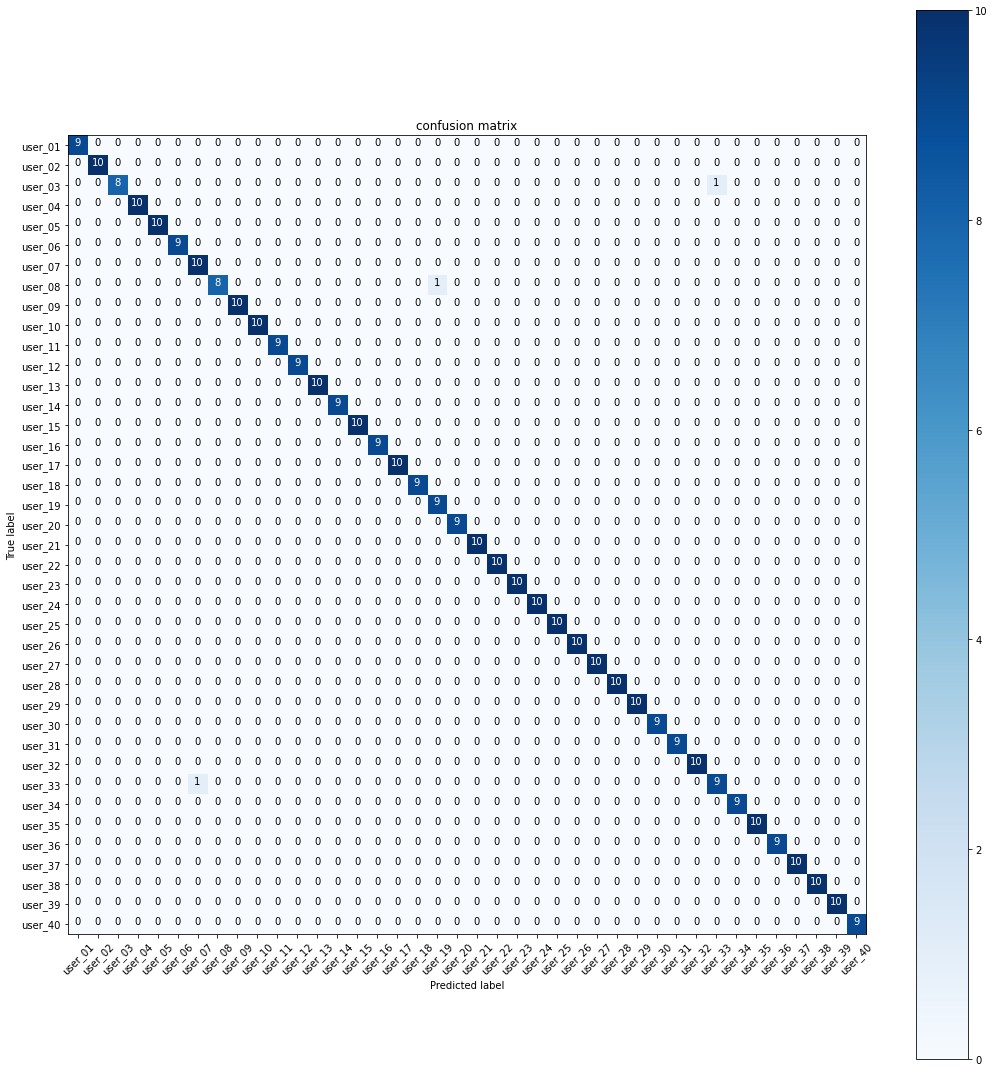

In [ ]:
cnf_matrix_usr = user_Identification_Evaluaion(trainCNN, X_Test_FL, c_usr_Test_FL, user_classes_FL)

We evaluate the performance on the testing set using the following metrics: False Rejection Rate (FRR): the fraction of genuine signatures rejected as forgeries; False Acceptance Rate (FARrandom and FARskilled): the fraction of forgeries accepted as genuine (considering random forgeries and skilled forgeries). We also report the Equal Error Rate (EER): which is the error when FAR = FRR.We considered two forms of calculating the EER: EERuser thresholds: using user-specific decision thresholds; and EERglobal threshold: using a global decision threshold. In both cases, to calculate the Equal Error Rate we only considered skilled forgeries (not random forgeries) - that is, we use only FRR and FARskilled to estimate the optimum threshold and report the Equal Error Rate. We also report the mean Area Under the Curve (AUC), considering ROC curves created for each user individually. For calculating FAR and FRR in the GPDS exploitation set, we used a decision threshold selected from the validation set Vv (the threshold that achieved EER using a global decision threshold). For the Brazilian PUC-PR dataset, we followed the convention of previous research in this
dataset, and also report the individual errors (False Rejection Rate and False Acceptance Rate for different types of forgery) and the Average error rate, calculate as AER = (FRR + FARrandom + FARsimple + FARskilled)/4. Since in this work we are mostly interested in the problem of distinguishing genuine signatures and skilled forgeries, we also report AERgenuine + skilled = (FRR + FARskilled)/2.

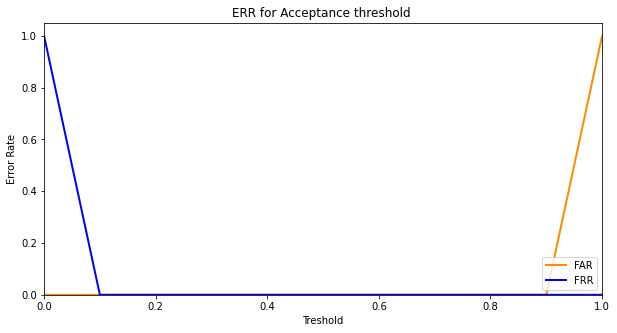

In [ ]:
ERR_FAR_vs_FRR_plot(FAR_Res, FRR_Res, thresholds)

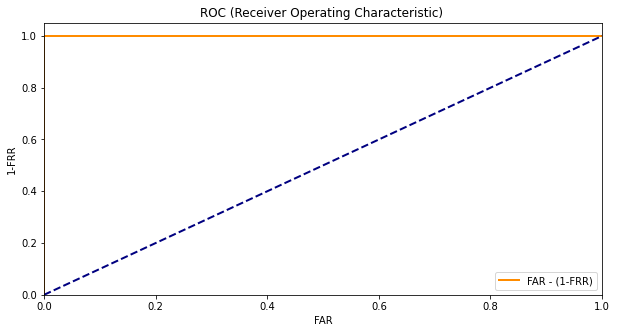

In [ ]:
ROC_Curve_plot(FAR_Res, FRR_Res)

INFO ..... user identidication  ..... 



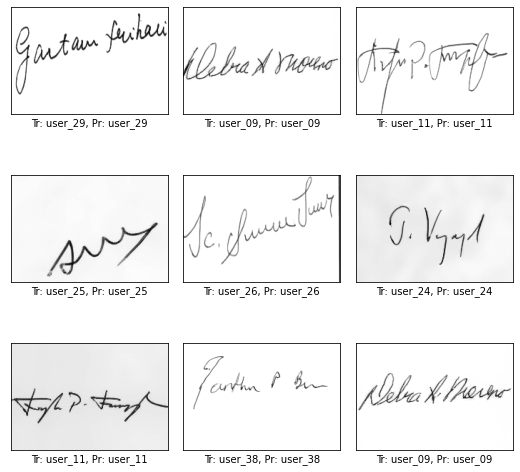

INFO ..... Genuine/Forgery identidication ..... 



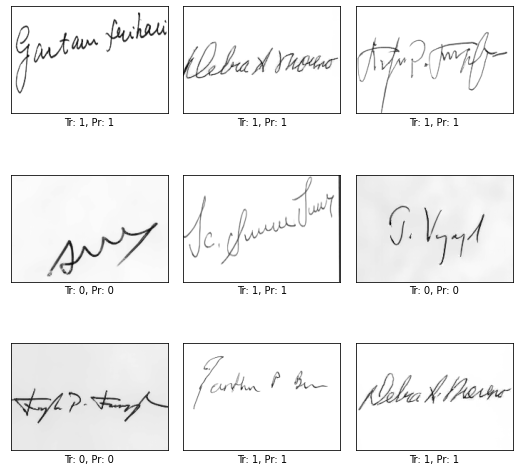

In [ ]:
threshold = 0.5
usr_pred_proba = trainCNN.predict_usr_proba(X_Test_FL)
Res_pred_proba = trainCNN.predict_Res_proba(X_Test_FL)
usr_pred, Res_pred = trainCNN.predict(usr_pred_proba, Res_pred_proba, user_classes, threshold)    

# Plot the images and labels using our helper-function above.
print("INFO ..... user identidication  ..... \n")
plot_9_pred_images(images= X_Test_FL[0:9], width= IMAGE_WIDTH, height= IMAGE_HEIGHT, cls_true= c_usr_Test_FL[0:9], cls_pred= usr_pred[0:9])  

print("INFO ..... Genuine/Forgery identidication ..... \n")
plot_9_pred_images(images= X_Test_FL[0:9], width= IMAGE_WIDTH, height= IMAGE_HEIGHT, cls_true= Res_Test_FL[0:9], cls_pred= Res_pred[0:9])

In [ ]:
Res_mistakes_Truth = []
Res_mistakes_pred = []
Res_mistakes_img = []
User_mistakes_Truth = []
User_mistakes_pred = []
User_mistakes_img = []
for i in range(len(Res_Test_FL)):
    if Res_Test_FL[i] != Res_pred[i]:
        Res_mistakes_Truth.append(int(Res_Test_FL[i]))
        Res_mistakes_pred.append(Res_pred[i])
        Res_mistakes_img.append(X_Test_FL[i])
    if c_usr_Test_FL[i] != usr_pred[i]:
        User_mistakes_Truth.append(c_usr_Test_FL[i])
        User_mistakes_pred.append(usr_pred[i])
        User_mistakes_img.append(X_Test_FL[i])

print(Res_mistakes_Truth)
print(Res_mistakes_pred)

print(User_mistakes_Truth)
print(User_mistakes_pred)

[]
[]
['user_08', 'user_33', 'user_03']
['user_19', 'user_07', 'user_33']


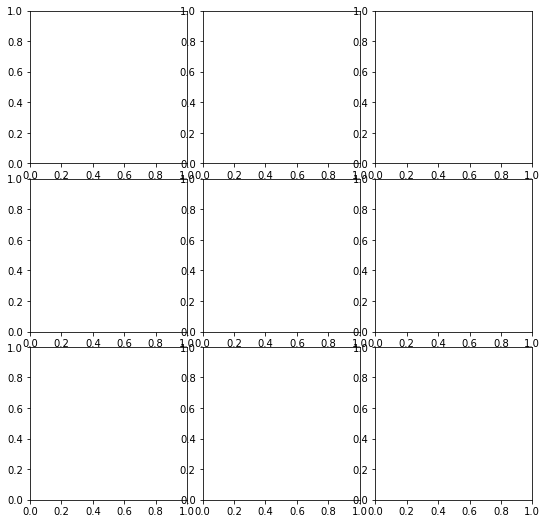

In [ ]:
# Plot the images and labels using our helper-function above.
plot_9_pred_images(images=Res_mistakes_img[0:9], width= IMAGE_WIDTH, height= IMAGE_HEIGHT, cls_true=Res_mistakes_Truth[0:9], cls_pred=Res_mistakes_pred[0:9])  

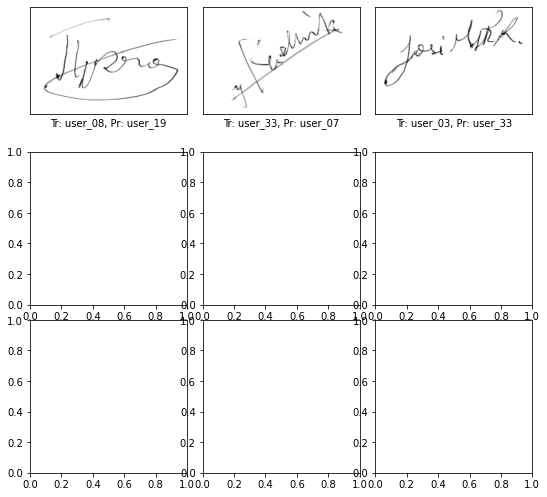

In [ ]:
# Plot the images and labels using our helper-function above.
plot_9_pred_images(images=User_mistakes_img, width= IMAGE_WIDTH, height= IMAGE_HEIGHT, cls_true=User_mistakes_Truth, cls_pred=User_mistakes_pred)  

# Single Test Image for Identification and verification from CNN model.

In [ ]:
TRAIN = False
originalPaper = False
origEpochs = 20
ourEpoch = 30
batch_size = 64

num_usr_FL = len(usr_FL_LB[1])
dataset_name1 = dataset_name
fc1_Size, fc2_Size = 1024, 1024

model = None
trainCNN = TrainCNN(model, num_usr_FL, originalPaper, origEpochs, ourEpoch, batch_size, IMAGE_WIDTH, IMAGE_HEIGHT, dataset_name1, fc1_Size, fc2_Size)

# Loading CNN model
trainCNN.load_CNN_model(20)

INFO .... Our Model
INFO .... Model Loaded .... 


In [ ]:
def SingleTestImg(img_Add, threshold):
    img = cv2.imread(img_Add ,cv2.IMREAD_GRAYSCALE)
    print("Raw Signature \n")    
    plt.imshow(img)
    plt.show()
    
    img = 255 - img # invert the pixels signature pixels are around 200 in pixels
    print("After Inverting Signature \n")
    plt.imshow(img)
    plt.show()
    
    img = cv2.resize(img,(IMAGE_WIDTH, IMAGE_HEIGHT)) # resize our images to be in same dimension for CNN        
    print("After Resize Signature \n")
    plt.imshow(img)
    plt.show()

    _, thresh1 = cv2.threshold(img,15,1,cv2.THRESH_BINARY) # return mask in binary format
    img = img * thresh1   
    print("After threshold applying Signature \n")
    plt.imshow(img)
    plt.show()

    img = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
    print("Preprocessed Signature \n")
    plt.imshow(img)
    plt.show()

    img = np.expand_dims(img, axis=2)
    img = np.expand_dims(img, axis=0)
    img = np.asarray(img)

    print("input for model shape", img.shape)

    """ User prediction section based on argmax """
    usr_pred_proba = trainCNN.predict_usr_proba(img)
    Res_pred_proba = trainCNN.predict_Res_proba(img)

    usr_pred = np.argmax(usr_pred_proba, axis = 1)
    pred_usr = usrAllLabelBinarizer.classes_[usr_pred[0]]
    pred_Res = (Res_pred_proba >= threshold)[0]

    return pred_usr, pred_Res


Raw Signature 



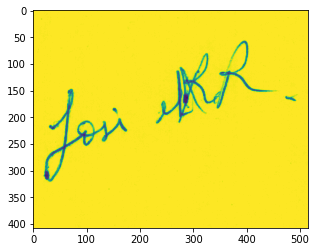

After Inverting Signature 



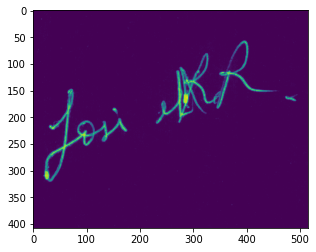

After Resize Signature 



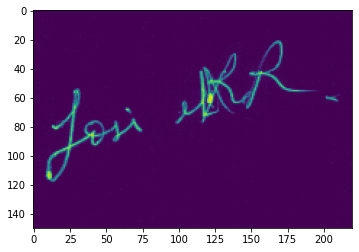

After threshold applying Signature 



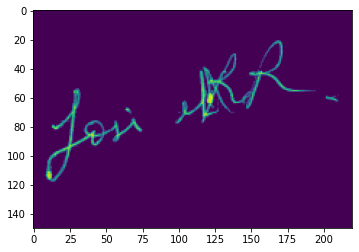

Preprocessed Signature 



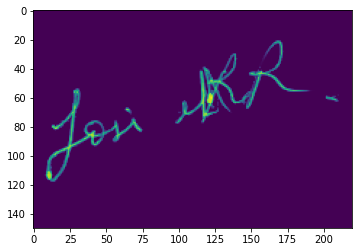

input for model shape (1, 150, 220, 1)


In [ ]:
threshold = 0.4
Forg = True
if Forg:
    img_Add = root_path + "/forgeries_3_2.png"
    claimed_usr = "user_03"
else:
    img_Add = root_path + "/original_5_1.png"
    claimed_usr = "user_06"

pred_usr, pred_Res = SingleTestImg(img_Add, threshold)


In [ ]:

print("\npred_usr: ", pred_usr, " - ", "pred_Res: ", pred_Res)



pred_usr:  user_03  -  pred_Res:  [ True]


In [ ]:
if claimed_usr == pred_usr:
    print("\n[Access Attempt for User] : ", claimed_usr)
    if pred_Res == True:
        print("\n[Forgery Attempt for] : ", claimed_usr)
        print("\n[Access Denied ....] ")
    else:
        print("[Original Attempt for] : ", claimed_usr)
        print("\n[.... Welcome ....] ", claimed_usr)
else:
    print("\n[Signature is not for User]: ", claimed_usr)
    print("\n[Access Denied ....] ")


[Access Attempt for User] :  user_03

[Forgery Attempt for] :  user_03

[Access Denied ....] 


In [ ]:
Thank you!

In [ ]:
# threshold = 0.4
# Forg = True
# if Forg:
#     img_Add = root_path + "/forgeries_3_2.png"
#     claimed_usr = "user_03"
# else:
#     img_Add = root_path + "/original_5_1.png"
#     claimed_usr = "user_06"

# pred_usr, pred_Res = SingleTestImg(img_Add, threshold)


# print("\npred_usr: ", pred_usr, " - ", "pred_Res: ", pred_Res)


# if claimed_usr == pred_usr:
#     print("\n[Access Attempt for User] : ", claimed_usr)
#     if pred_Res == True:
#         print("\n[Forgery Attempt for] : ", claimed_usr)
#         print("\n[Access Denied ....] ")
#     else:
#         print("[Original Attempt for] : ", claimed_usr)
#         print("\n[.... Welcome ....] ", claimed_usr)
# else:
#     print("\n[Signature is not for User]: ", claimed_usr)
#     print("\n[Access Denied ....] ")
